# 7: Segmenting the detected objects in the images
In order to further augment the images, the detected objects are segmented in the images. The bounding boxes from the phrase grounding results are used to crop the objects and then segment them. Initially, GrabCut was chosen for this task due to its simplicity, but its performance was disappointing, especially on black and white images, which make up the majority of the dataset. As a result, a custom segmentation deep learning model was designed using PyTorch.

## Design of the model
The [Segmentation Models](https://github.com/qubvel/segmentation_models.pytorch)  library was used to design the model, which provides a wide range of pretrained segmentation models. The chosen architecture is a  [U-Net](https://arxiv.org/abs/1505.04597) with a [ResNet34](https://arxiv.org/abs/1512.03385) encoder, pretrained on the [Image-Net](https://www.image-net.org/index.php) dataset. This provides a good balance between inference speed and the quality of the segmentation.

## Fine-tuning
The model was fine-tuned on a subset of the [COCO-2014](https://cocodataset.org/#home) dataset, which consists of 5’000 images with bounding boxes and segmentation masks. The following process was used for fine-tuning the model:

The process of fine-tuning the model is as follows:
* The image is resized to 352x352, normalized, converted to black and white and then turned into a tensor. The bounding box is used to create a mask of the object in the image.
* The image is multiplied by the mask to remove the background and is used as the input to the model. 
* The image is used as the input to the model, and the segmentation ground truth is used as the target for the model.

The model is trained for 100 epochs, using the [Adam](https://arxiv.org/abs/1412.6980) optimizer and the [Dice Loss](https://arxiv.org/abs/1707.03237) as the loss function.

In [1]:
import json
import pickle
import re
from itertools import compress

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from segmentation import SegmentationModel, apply_mask, plot_results
from torchvision.ops import nms
from tqdm import tqdm

In [2]:
segmentation_results_dir = '../data/segmentation_results/'
segmentation_results_dir = '../docs/images/gallery/'
image_folder = '../data/BCU_database/03_resized/'

In [3]:
dataset = pickle.load(open('../data/dataset_for_segmentation.p', 'rb'))
dataset.head()

,idx,filename,caption,model,expr,conf,bbox,labels,image_id,caption_raw,caption_preprocessed,title_raw,title_preprocessed
0,1027,JOMU_32980_2k_324w.jpg,people buying sweets at the market.,GLIP,caption,"[tensor(0.8280), tensor(0.7924), tensor(0.6899...","[[tensor(178.8594), tensor(116.5122), tensor(2...","[people, people, people, people, people, peopl...",1488.0,people buying sweets at the market.,people buying sweets at the market.,"Saint Nicholas Festival Market, Place de Notre...","saint nicholas festival market, place de notre..."
1,183,CAPO_02480_2k_324w.jpg,a group of soldiers stand in front of a building.,GLIP,caption,"[tensor(0.8242), tensor(0.5884), tensor(0.5781...","[[tensor(0.8775), tensor(131.9302), tensor(81....","[soldiers, a building, a building, a building]",516.0,a group of soldiers stand in front of a building.,a group of soldiers stand in front of a building.,[Mobilization at Perolles in August 1914],[mobilization at perolles in august 1914]
2,543,JATH_26232_2k_324w.jpg,soldiers stand in front of a military vehicle.,GLIP,caption,"[tensor(0.7898), tensor(0.7305), tensor(0.6872...","[[tensor(97.0861), tensor(137.5495), tensor(14...","[soldiers, soldiers, a military vehicle, soldi...",950.0,soldiers stand in front of a military vehicle.,soldiers stand in front of a military vehicle.,"Additional service for women, Barracks de la P...","additional service for women, barracks de la p..."
3,430,JATH_10616_2k_324w.jpg,women walking down a street.,GLIP,caption,"[tensor(0.6900), tensor(0.6777), tensor(0.6676...","[[tensor(125.4207), tensor(111.6184), tensor(1...","[women, women, women, a street, women]",836.0,women walking down a street.,women walking down a street.,Procession on the route to the Alps during a w...,procession on the route to the alps during a w...
4,408,HAWI_01023_2k_324w.jpg,a photograph of a large tropical cyclone.,GLIP,caption,[tensor(0.7263)],"[[tensor(4.5861), tensor(13.1419), tensor(318....",[a large tropical cyclone],814.0,a photograph of a large tropical cyclone.,a a large tropical cyclone.,Tornado over Lake Morat,tornado over lake morat


### Runs the model on the images

In [4]:
model = SegmentationModel('../model/model_segmentation.pth', device='cuda')

0it [00:00, ?it/s]

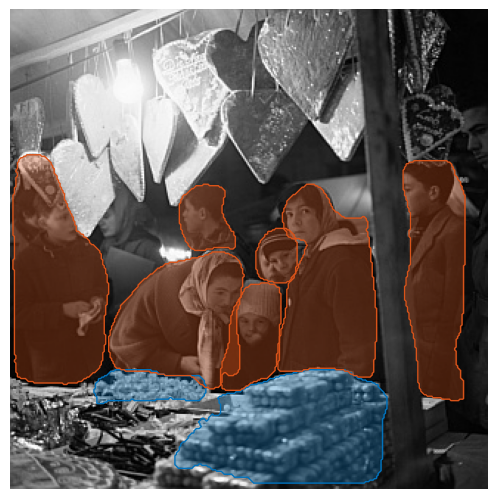

1it [00:00,  2.98it/s]

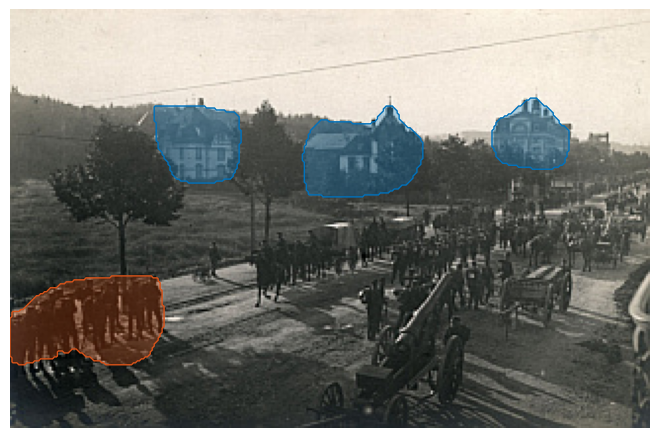

2it [00:00,  3.69it/s]

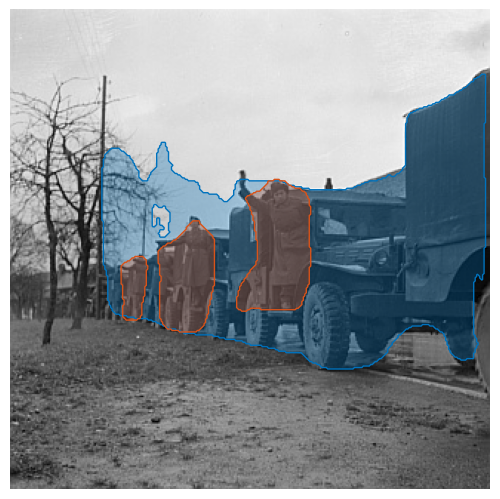

3it [00:00,  4.13it/s]

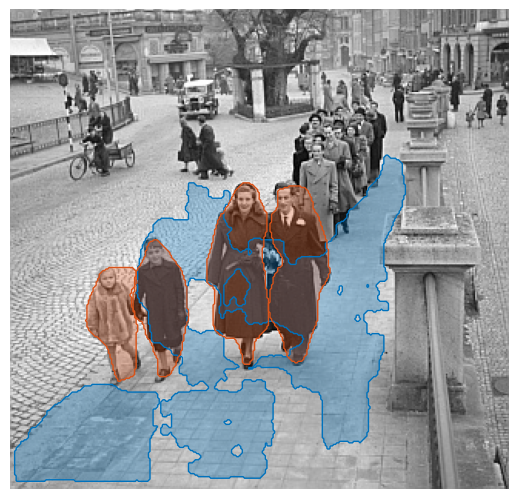

4it [00:01,  3.92it/s]

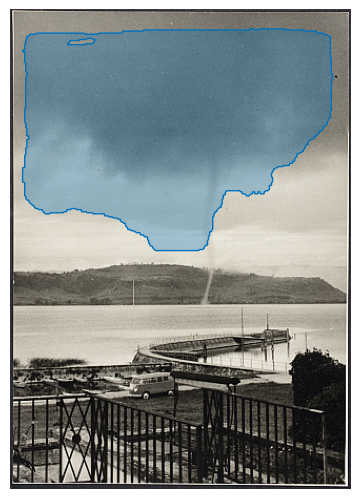

5it [00:01,  4.51it/s]

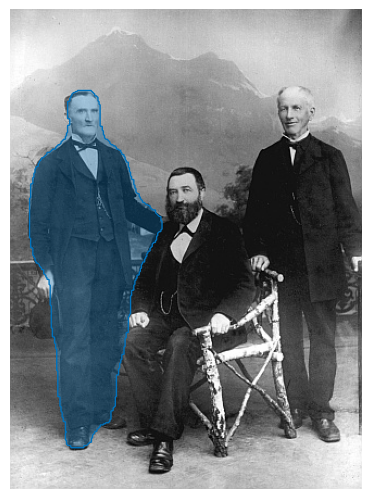

6it [00:01,  5.28it/s]

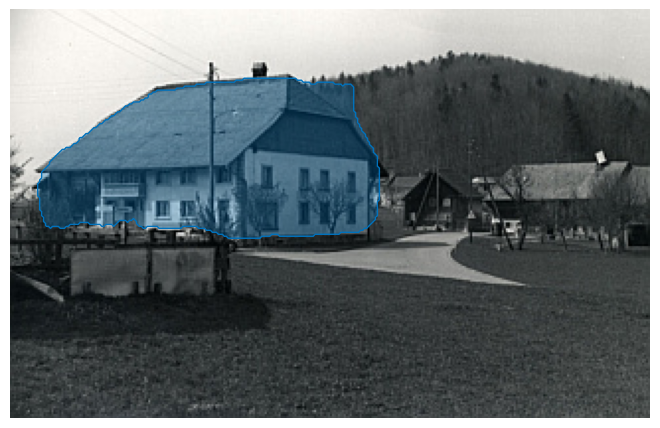

6it [00:01,  4.04it/s]


In [6]:
figure = plt.figure()
from time import time
titles = dict()

for i, data in tqdm(dataset.iterrows()):
    img = np.array(Image.open(image_folder + data['filename']).convert("RGB"))

    segmentation_masks = model.single_inference(img, data)
    if segmentation_masks is not None:

        ax = plt.gca()
        title = plot_results(img.astype(int), data, expression=data['caption'], segmentations=segmentation_masks, ax=ax, conf=0)
        titles[data['filename']] = title

        plt.tight_layout(pad=0)
        plt.show()

        # Save the plot to a file
        # plt.savefig(segmentation_results_dir + data['filename'], bbox_inches="tight")
        # plt.cla()
    

### Transforms the colored captions to HTML code

In [ ]:
captions = dict()

# Iterate over the items in the JSON object
for image, image_data in titles.items():
    # Get the text and color data for the image
    text = image_data["text"]
    colors = image_data["colors"]

    # Create an empty list to store the HTML text
    html_text = []

    # Iterate over the text and color data
    for i in range(len(text)):
        # Convert the RGB color values to hexadecimal
        color = "#{:02x}{:02x}{:02x}".format(
            int(colors[i][0] * 255),
            int(colors[i][1] * 255),
            int(colors[i][2] * 255)
        )

        # Add the text and color to the HTML text list
        html_text.append(f'<span style="color: {color}">{text[i]}</span>')

    # Join the HTML text list into a single string
    html_text = "".join(html_text)
    captions[image] = html_text
    # Print the HTML text for the image

In [ ]:
# save captions
with open('../docs/_data/captions.json', 'w') as f:
    json.dump(captions, f)